In [1]:
first_time = True

In [2]:
# --- Standard Library ---
import math
import random
import time
import warnings
from collections import defaultdict
from datetime import datetime, timedelta, timezone

# --- Third-party Libraries ---
import numpy as np
import pandas as pd
import ijson
import dtale

# --- Matplotlib ---
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import Rectangle, Polygon as MplPolygon
from matplotlib.ticker import FixedLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- Shapely ---
from shapely.geometry import (
    Polygon, MultiPolygon, LineString, GeometryCollection, box
)
from shapely.ops import unary_union, polygonize

# --- IPython / Widgets ---
from IPython.display import display
from ipywidgets import Checkbox, HBox, VBox, HTML

# --- Interactive Tools ---
import mplcursors

# --- Enable Interactive Plotting ---
%matplotlib widget


In [3]:
import os

# Only define injected_file_path if not set externally
try:
    injected_file_path
except NameError:
    injected_file_path = "/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json"

# Always assign file_path
file_path = injected_file_path

file_id = os.path.splitext(os.path.basename(file_path))[0]

# Extract post folder (assumes format has '__postX' at the end)
post_folder = file_id.split("__")[-1]  # e.g. 'post1'
output_dir = os.path.join("./output", post_folder)
os.makedirs(output_dir, exist_ok=True)

# Plot counter starts at 0 for each notebook run
plot_counter = 0


In [4]:
def save_plot(name_suffix):
    global plot_counter
    plot_counter += 1
    filename = f"{output_dir}/plot_{file_id}_{plot_counter}_{name_suffix}.png"
    plt.savefig(filename, dpi=300)
    print(f"Saved plot to {filename}")

In [5]:
def save_df(df, name_suffix):
    filename = f"{output_dir}/df_{file_id}_{name_suffix}.csv"
    df.to_csv(filename, index=False)
    print(f"Saved DataFrame to {filename}")

In [6]:
# Convert timestamp to Edie time bin
def time_bin(t, dt):
    return int(t // dt)

# Convert x-position to Edie space bin
def space_bin(x, dx):
    return int(x // dx)

# Create the main parser and Edie statistics accumulator
def compute_edie_stats_threshold(file_path, direction=-1, dx=160, dt=60, light_thresh=20, heavy_thresh=10):
    edie_grid = defaultdict(lambda: {"distance": 0.0, "time": 0.0, "count": 0})
    got_date = False
    count = 0

    with open(file_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item', use_float=True)

        for record in parser:
            if record["direction"] != direction:
                continue

            timestamps = np.array(record["timestamp"])
            x_positions = np.array(record["x_position"])
            if len(timestamps) < 2:
                continue

            if not got_date:
                date = datetime.fromtimestamp(timestamps[0]).date()
                got_date = True

            for i in range(1, len(timestamps)):
                t0, t1 = timestamps[i - 1], timestamps[i]
                x0, x1 = x_positions[i - 1], x_positions[i]

                dt_seg = t1 - t0
                dx_seg = (x1 - x0) * direction
                if dt_seg <= 0 or dx_seg <= 0:
                    continue

                t_bins = list(range(time_bin(t0, dt), time_bin(t1, dt) + 1))
                x_bins = list(range(space_bin(x0, dx), space_bin(x1, dx) + 1))

                for tb in t_bins:
                    for xb in x_bins:
                        edie_grid[(xb, tb)]["distance"] += dx_seg
                        edie_grid[(xb, tb)]["time"] += dt_seg
                        edie_grid[(xb, tb)]["count"] += 1

            count += 1
            if count % 100000 == 0:
                print(f"Processed {count} trajectories...")

    print(f"✅ Finished parsing {count} trajectories.")
    
    # Apply dual threshold filtering
    edie_grid_light = {}
    edie_grid_heavy = {}

    for key, cell in edie_grid.items():
        if cell["time"] == 0:
            continue
        speed_mph = (cell["distance"] / cell["time"]) * 3600 / 5280
        if speed_mph <= light_thresh:
            edie_grid_light[key] = cell
        if speed_mph <= heavy_thresh:
            edie_grid_heavy[key] = cell

    print(f"🌕 Edie cells ≤ {light_thresh} mph: {len(edie_grid_light)}")
    print(f"🔴 Edie cells ≤ {heavy_thresh} mph: {len(edie_grid_heavy)}")

    return edie_grid_light, edie_grid_heavy, date



def union_parallelograms(parallelograms):
    print("🔁 Unioning parallelograms...")
    t0 = time.time()
    merged = unary_union(parallelograms)
    t1 = time.time()
    print(f"✅ Union complete in {t1 - t0:.2f} seconds.")
    return merged

def create_tilted_parallelogram(x, t, speed, length=200, time_span=60):
    """
    Create a parallelogram centered at (x, t), tilted according to speed.
    - x in feet, t in seconds
    - speed in mph
    """
    mph_to_ftps = 1.46667
    slope = speed * mph_to_ftps  # ft/s
    
    half_len = length / 2
    half_time = time_span / 2
    
    # Compute corners with tilt
    corners = [
        (t - half_time, x - slope * half_time - half_len),
        (t - half_time, x - slope * half_time + half_len),
        (t + half_time, x + slope * half_time + half_len),
        (t + half_time, x + slope * half_time - half_len),
    ]
    return Polygon(corners)


def split_by_thin_connections(polygons, buffer_distance=100):
    """
    For each polygon in the input list, apply erosion followed by dilation.
    This removes thin connections, possibly splitting a polygon into multiple parts.
    
    Args:
        polygons (List[Polygon]): List of input polygons
        buffer_distance (float): Buffer distance for erosion and dilation
    
    Returns:
        List[Polygon]: All resulting polygons after split
    """
    results = []

    for i, poly in enumerate(polygons):
        if poly.is_empty or not isinstance(poly, Polygon):
            continue

        # Erode (shrink) to remove narrow connections
        eroded = poly.buffer(-buffer_distance)
        if eroded.is_empty:
            continue

        # Dilate (expand back to original size)
        dilated = eroded.buffer(buffer_distance)

        # Collect individual polygons
        if isinstance(dilated, (MultiPolygon, GeometryCollection)):
            parts = [g for g in dilated.geoms if isinstance(g, Polygon) and not g.is_empty]
            results.extend(parts)
        elif isinstance(dilated, Polygon):
            results.append(dilated)

    return results




def build_all_parallelograms(points, speeds, length=200, time_span=60):
    parallelograms = []
    n_points = len(points)
    print(f"Building parallelograms for {n_points} points...")
    for i, ((x, t), speed) in enumerate(zip(points, speeds)):
        if i % 100000 == 0 and i > 0:
            print(f"  Processed {i} points...")
        poly = create_tilted_parallelogram(x, t, speed, length, time_span)
        parallelograms.append(poly)
    print(f"Done creating {len(parallelograms)} parallelograms.")
    return parallelograms

def filter_polygons_by_area(polygons, min_area=10000):
    """
    Filter polygons, keeping only those with area >= min_area.
    """
    if hasattr(polygons, "geoms"):
        poly_list = list(polygons.geoms)
    else:
        poly_list = [polygons]

    kept_polygons = [poly for poly in poly_list if poly.area >= min_area]

    print(f"Filtered {len(poly_list)} polygons down to {len(kept_polygons)} by area >= {min_area}")
    return kept_polygons


def find_congestion_segments_dual(
    file_path,
    traj_threshold_seconds=10,
    direction=-1,
    light_thresh=20,
    heavy_thresh=10,
    min_distance_feet=1,
):
    light_segments = []
    heavy_segments = []
    date = None
    got_date = False
    count = 0

    with open(file_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item', use_float=True)

        for record in parser:
            if record["direction"] != direction:
                continue

            duration = record["last_timestamp"] - record["first_timestamp"]
            if duration < traj_threshold_seconds:
                continue

            if not got_date:
                date = datetime.fromtimestamp(record["first_timestamp"]).date()
                got_date = True

            x_pos = np.array(record["x_position"])
            timestamp = np.array(record["timestamp"])

            # Calculate speed (ft/s → mph)
            speed = np.diff(x_pos) / np.diff(timestamp) * direction
            speed = np.append(speed[0], speed)
            speed *= 0.681818

            def extract_segments(threshold):
                segments = []
                mask = (speed > 0) & (speed <= threshold)
                in_segment = False
                segment_start = 0

                for i in range(len(mask)):
                    if mask[i] and not in_segment:
                        segment_start = i
                        in_segment = True
                    elif not mask[i] and in_segment:
                        segment_end = i - 1
                        in_segment = False
                        distance = x_pos[segment_end] - x_pos[segment_start]
                        if distance * direction >= min_distance_feet:
                            segments.append({
                                "x_position": [x_pos[segment_start], x_pos[segment_end]],
                                "timestamp": [timestamp[segment_start], timestamp[segment_end]],
                                "speed_mph": [speed[segment_start], speed[segment_end]],
                            })

                if in_segment:
                    segment_end = len(mask) - 1
                    distance = x_pos[segment_end] - x_pos[segment_start]
                    if distance * direction >= min_distance_feet:
                        segments.append({
                            "x_position": [x_pos[segment_start], x_pos[segment_end]],
                            "timestamp": [timestamp[segment_start], timestamp[segment_end]],
                            "speed_mph": [speed[segment_start], speed[segment_end]],
                        })
                return segments

            light_segments.extend(extract_segments(light_thresh))
            heavy_segments.extend(extract_segments(heavy_thresh))

            count += 1
            if count % 100000 == 0:
                print(f"Processed {count} trajectories...")

    print(f"✅ Finished parsing {count} trajectories.")
    print(f"{file_path}, {date} → Found (light={len(light_segments)}, heavy={len(heavy_segments)}) segments.")
    return light_segments, heavy_segments, date

def simplify_polygons(polygons, tolerance=1000):
    # If MultiPolygon, simplify each geometry
    if hasattr(polygons, "geoms"):
        simplified_geoms = [poly.simplify(tolerance, preserve_topology=True) for poly in polygons.geoms]
        return MultiPolygon(simplified_geoms)
    elif isinstance(polygons, Polygon):
        return polygons.simplify(tolerance, preserve_topology=True)
    else:
        # If it's a list of polygons
        simplified = [poly.simplify(tolerance, preserve_topology=True) for poly in polygons]
        return simplified

def fill_polygon_gaps(polygons, buffer_distance=100):
    """
    Slightly dilate (expand) each polygon and merge with the original to fill small gaps.
    
    Args:
        polygons (List[Polygon]): Input polygons
        buffer_distance (float): Distance to buffer for filling
    
    Returns:
        List[Polygon]: Cleaned, gap-filled polygons
    """
    filled_polygons = []
    
    for poly in polygons:
        if poly.is_empty or not isinstance(poly, Polygon):
            continue
        
        # Expand slightly
        dilated = poly.buffer(buffer_distance)
        
        # Merge with original to preserve finer detail
        merged = poly.union(dilated)

        # Simplify topology (optional)
        if isinstance(merged, (MultiPolygon, GeometryCollection)):
            parts = [g for g in merged.geoms if isinstance(g, Polygon)]
            filled_polygons.extend(parts)
        else:
            filled_polygons.append(merged)
    
    return filled_polygons


def create_congestion_zones(
    trajs,
    length=250,
    time_span=30,
    min_area=500000,
    simplify_tolerance=0,
    label=None,
    union=True,
    detailed_zone = True,
    min_area_hulls=500000,
    buffer_distance=None,
    fill_gaps_distance=None,
):
    """
    From a list of trajectory segments, extract points/speeds,
    and either return raw parallelograms or a unified simplified polygon.

    Returns:
        - If union=True: simplified unioned polygon
        - If union=False: list of raw parallelograms (no filtering/simplifying)
    """
    print(f"\n🔹 Building congestion polygon for: {label or 'Unnamed'}")
    t0 = time.time()

    # Step 1: Extract points and speeds
    all_points = []
    all_speeds = []
    for traj in trajs:
        if "x_position" in traj:
            all_points.extend(zip(traj["x_position"], traj["timestamp"]))
        else:
            all_points.append((traj["x"], traj["t"]))
        all_speeds.extend(traj["speed_mph"])
    t1 = time.time()
    print(f"✅ Extracted {len(all_points)} points in {t1 - t0:.2f}s.")

    # Step 2: Build parallelograms
    print("🔹 Building parallelograms...")
    parallelograms = build_all_parallelograms(all_points, all_speeds, length=length, time_span=time_span)

    if not union:
        print(f"✅ Returning {len(parallelograms)} raw parallelograms (no union/filter/simplify).")
        return parallelograms

    # Step 3: Union, filter, simplify
    print("🔹 Unioning and simplifying polygons...")
    congestion_polygon = union_parallelograms(parallelograms)
    filtered_by_area = filter_polygons_by_area(congestion_polygon, min_area=min_area)

    # ➕ Erosion-Dilation Split
    if buffer_distance is not None:
        print(f"🔻 Applying erosion-dilation (buffer = {buffer_distance})...")
        filtered_by_area = split_by_thin_connections(filtered_by_area, buffer_distance=buffer_distance)
        print(f"✅ Polygons after erosion-dilation split: {len(filtered_by_area)}")

    if fill_gaps_distance is not None:
        print(f"🩹 Filling small gaps with buffer = {fill_gaps_distance}...")
        filtered_by_area = fill_polygon_gaps(filtered_by_area, buffer_distance=fill_gaps_distance)
        print(f"✅ Polygons after filling gaps: {len(filtered_by_area)}")

    if detailed_zone: 
        t2 = time.time()
        simplified = simplify_polygons(filtered_by_area, tolerance=simplify_tolerance)
        print(f"✅ Detalied Zone Polygons processed in {t2 - t1:.2f}s (Total: {t2 - t0:.2f}s).")
        return simplified

    convexified = [poly.convex_hull for poly in filtered_by_area]

    # Merge convex hulls back together
    merged_convex = unary_union(convexified)

    # Normalize to list
    if isinstance(merged_convex, (MultiPolygon, GeometryCollection)):
        merged_list = [g for g in merged_convex.geoms if isinstance(g, Polygon)]
    else:
        merged_list = [merged_convex]

# ✅ Filter by area
    final_polygons = [poly for poly in merged_list if poly.area >= min_area_hulls]
    t2 = time.time()
    print(f"✅ Polygon processed in {t2 - t1:.2f}s (Total: {t2 - t0:.2f}s).")
    return final_polygons
    
def edie_cell_to_polygon(x_bin, t_bin, dx=160, dt=30):
    x0 = x_bin * dx / 5280
    x1 = (x_bin + 1) * dx / 5280
    t_start = t_bin * dt
    t_end = (t_bin + 1) * dt
    
    # The corners of the rectangle in (time, mile_marker) coordinates
    corners = [
        (t_start, x0),
        (t_start, x1),
        (t_end, x1),
        (t_end, x0),
        (t_start, x0),  # Close polygon by repeating the first point
    ]
    
    return Polygon(corners)


def interactive_plot_edies_polys(trajectories, patches_by_label):
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(12, 4))

    # Plot trajectories (invisible points, colorbar still works)
    all_timestamps = []
    all_positions = []
    all_speeds = []
    for traj in trajectories:
        all_timestamps.extend(traj["timestamp"])
        all_positions.extend(np.array(traj["x_position"]) / 5280)
        all_speeds.extend(traj["speed_mph"])

    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)
    norm = Normalize(vmin=0, vmax=55)

    im = ax.scatter(all_timestamps, all_positions, c=all_speeds,
                    cmap=green_to_red, vmin=0, vmax=80, s=0.1, alpha=0)

    # Colorbar
    sm = ScalarMappable(cmap=green_to_red, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Speed (mph)', pad=0.01)

    # Format time axis
    ticks_loc = ax.get_xticks().tolist()
    ax.set_xticks(ticks_loc)
    labels = [datetime.fromtimestamp(ts, tz=timezone(timedelta(hours=-6))).strftime('%H:%M:%S') for ts in ticks_loc]
    ax.set_xticklabels(labels, rotation=45)
    ax.set_xlabel("Time")
    ax.set_ylabel("Mile Marker")
    ax.invert_yaxis()

    # Hover display
    def format_hover_info(x, y):
        try:
            dt = datetime.fromtimestamp(x, tz=timezone(timedelta(hours=-6)))
            return f"Time: {dt.strftime('%H:%M')}, Mile: {y:.2f}"
        except:
            return f"Time: {x:.2f}, Mile: {y:.2f}"
    ax.format_coord = format_hover_info

    # --- TOGGLES ---
    patches_controls = {}
    toggles = []

    for label, patches in patches_by_label.items():
        for patch in patches:
            ax.add_patch(patch)

        checkbox = Checkbox(value=True, indent=False, layout={'width': '15px'})
        color = patch.get_facecolor() if patches else "black"
        label_html = HTML(f"<span style='color:{mcolors.to_hex(color)}; font-weight:bold;'>{label.replace('_', ' ').title()}</span>")
        toggles.append(HBox([checkbox, label_html], layout={'align_items': 'center', 'gap': '4px'}))
        patches_controls[label] = (patches, checkbox)

    def update_display(change=None):
        for _, (patches, checkbox) in patches_controls.items():
            for patch in patches:
                patch.set_visible(checkbox.value)
        fig.canvas.draw_idle()

    for _, (_, checkbox) in patches_controls.items():
        checkbox.observe(update_display, names='value')

    update_display()
    display(VBox(toggles))
    plt.tight_layout()
    save_plot("cong_and_edie_poly")
    plt.show()

def build_edie_patches(edie_grid, dx, dt):
    """Convert edie_grid to colored matplotlib Rectangles."""

    # Colormap for Edies
    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
    cmap = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)
    norm = Normalize(vmin=0, vmax=55)

    patches = []
    for (x_bin, t_bin), cell in edie_grid.items():
        if cell["time"] == 0:
            continue
        speed_mph = (cell["distance"] / cell["time"]) * 3600 / 5280
        speed_for_color = min(speed_mph, 55)
        color = cmap(norm(speed_for_color))

        x0 = x_bin * dx / 5280
        x1 = (x_bin + 1) * dx / 5280
        t_start = t_bin * dt
        t_end = (t_bin + 1) * dt

        rect = Rectangle((t_start, x0), t_end - t_start, x1 - x0,
                         facecolor=color, edgecolor='none', alpha=1)
        patches.append(rect)
    return patches


def convert_polys_to_miles(polygons):
    """
    Converts the y-coordinates of all polygons in the list from feet to miles.

    Parameters:
        polygons (list[Polygon]): List of shapely Polygons in feet.

    Returns:
        list[Polygon]: New list with y-coordinates converted to miles.
    """
    converted = []
    for poly in polygons:
        # poly.exterior.coords gives a list of (x, y) vertices for the outer boundary
        # Only the y-coordinate is divided by 5280 to convert feet → miles
        coords = [(x, y / 5280) for x, y in poly.exterior.coords]
        converted.append(Polygon(coords))
    return converted

def build_polygon_patches(polygons, facecolor):
    """Create matplotlib polygon patches from shapely polygons."""
    patches = []
    for poly in polygons:
        coords = np.array(poly.exterior.coords)
        patch = MplPolygon(coords, facecolor=facecolor, edgecolor='black', linewidth=0.8)
        patches.append(patch)
    return patches

def compare_polygon_sets(edie_light, edie_heavy, light_polys_miles, heavy_polys_miles, dx, dt):
    """Convert Edie cells to polygons, combine with other polygon sets, and compute pairwise area coverage."""
    
    def edie_cells_to_polygons(edie_dict, dx, dt):
        """Convert Edie cell dictionary to a list of shapely polygons."""
        print(f"Converting {len(edie_dict)} Edie cells to polygons...")
        polys = []
        for (x_bin, t_bin), cell in edie_dict.items():
            if cell["time"] == 0:
                continue
            polys.append(edie_cell_to_polygon(x_bin, t_bin, dx, dt))
        print(f"Converted to {len(polys)} polygons (excluding zero-time cells).")
        return polys
    
    def total_area(polygons):
        """Calculate total area of a list of polygons."""
        return sum(p.area for p in polygons)
    
    # --- Step 1: Convert Edie cells ---
    print("Starting conversion of Edie light polygons...")
    edie_light_polygons = edie_cells_to_polygons(edie_light, dx, dt)
    
    print("Starting conversion of Edie heavy polygons...")
    edie_heavy_polygons = edie_cells_to_polygons(edie_heavy, dx, dt)
    
    # --- Step 2: Store all sets in a dict ---
    poly_sets = {
        "Light Edie": edie_light_polygons,
        "Heavy Edie": edie_heavy_polygons,
        "Light Poly": light_polys_miles,
        "Heavy Poly": heavy_polys_miles,
    }
    
    # --- Step 3: Pairwise area comparisons ---
    print("\nStarting pairwise area comparisons...\n")
    results = []
    for gt_name, gt_polys in poly_sets.items():
        gt_area = total_area(gt_polys)
        for pred_name, pred_polys in poly_sets.items():
            if gt_name == pred_name:
                continue
            pred_area = total_area(pred_polys)
            coverage_pct = (pred_area / gt_area * 100) if gt_area > 0 else 0
            results.append({
                "Truth": gt_name,
                "Approx.": pred_name,
                "Coverage %": coverage_pct
            })
    
    # --- Step 4: Sort & save ---
    print("\nPairwise area coverage results:")
    df_results = pd.DataFrame(results)
    df_results_sorted = df_results.iloc[(df_results["Coverage %"] - 100).abs().argsort()]
    df_results_sorted = df_results_sorted[["Approx.", "Truth", "Coverage %"]].round(2)
    
    save_df(df_results_sorted, "coverage")
    print(df_results_sorted)
    
    return df_results_sorted








In [7]:
DX_FEET = 0.02 * 5280 # 0.02 miles converted to feet
DT_SECONDS = 6 # 6 seconds 

edie_light, edie_heavy, date = compute_edie_stats_threshold(
    file_path=file_path,  # replace with actual file path
    dx=DX_FEET,        # 0.02 miles
    dt=DT_SECONDS,         # 6 seconds time resolution
    direction=-1,   # set the correct traffic direction
    light_thresh=20,
    heavy_thresh=10,
)

Processed 100000 trajectories...


Processed 200000 trajectories...


Processed 300000 trajectories...


Processed 400000 trajectories...


Processed 500000 trajectories...


✅ Finished parsing 586454 trajectories.
🌕 Edie cells ≤ 20 mph: 152820
🔴 Edie cells ≤ 10 mph: 71826


In [8]:
file_paths = [
    file_path, # change to multiple hardcoded if not using batch_run.py
]

all_rows = []

for path in file_paths:
    
    if first_time:
        trajs_light, trajs_heavy, date = find_congestion_segments_dual(
            path,
            light_thresh=20,
            heavy_thresh=10,
        )
        
    distance_to_cover = 250
    time_to_cover = 3
    min_area = 10000
    min_area_hulls = 50000
    simplify_tolerance = 0
    union_bool = True

    simplified_polygons_light = create_congestion_zones(
        trajs_light,
        length=250,
        time_span=30,
        min_area=500000,
        union=union_bool,
        detailed_zone=False,
        min_area_hulls=min_area_hulls,
        label="light_sub_20"
    )

    simplified_polygons_heavy = create_congestion_zones(
        trajs_heavy,
        length=500,
        time_span=5,
        min_area=50000,
        union=union_bool,
        detailed_zone=True,
        min_area_hulls=min_area_hulls,
        buffer_distance=5,
        fill_gaps_distance=5,
        label="heavy_sub_10"
    )
    
first_time = False

Processed 100000 trajectories...


Processed 200000 trajectories...


✅ Finished parsing 291564 trajectories.
/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json, 2022-11-21 → Found (light=188008, heavy=168265) segments.

🔹 Building congestion polygon for: light_sub_20
✅ Extracted 376016 points in 0.07s.
🔹 Building parallelograms...
Building parallelograms for 376016 points...


  Processed 100000 points...


  Processed 200000 points...


  Processed 300000 points...


Done creating 376016 parallelograms.
🔹 Unioning and simplifying polygons...
🔁 Unioning parallelograms...


✅ Union complete in 13.33 seconds.
Filtered 472 polygons down to 6 by area >= 500000
✅ Polygon processed in 17.33s (Total: 17.41s).

🔹 Building congestion polygon for: heavy_sub_10
✅ Extracted 336530 points in 0.07s.
🔹 Building parallelograms...
Building parallelograms for 336530 points...


  Processed 100000 points...


  Processed 200000 points...


  Processed 300000 points...


Done creating 336530 parallelograms.
🔹 Unioning and simplifying polygons...
🔁 Unioning parallelograms...


✅ Union complete in 9.86 seconds.
Filtered 1428 polygons down to 37 by area >= 50000
🔻 Applying erosion-dilation (buffer = 5)...


✅ Polygons after erosion-dilation split: 131
🩹 Filling small gaps with buffer = 5...


✅ Polygons after filling gaps: 131
✅ Detalied Zone Polygons processed in 21.97s (Total: 22.04s).


Saved plot to ./output/post1/plot_637b023440527bf2daa5932f__post1_1_cong_and_edie_poly.png


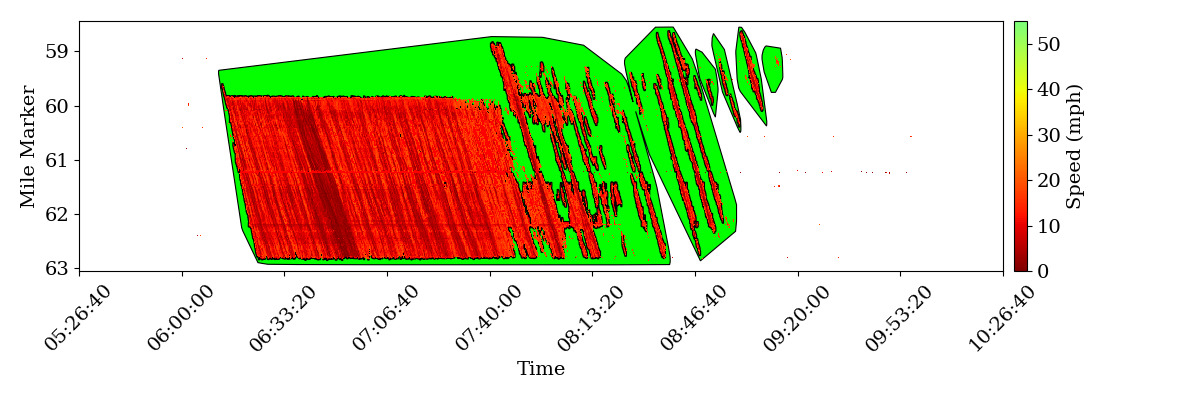

In [9]:
# Convert polygons to miles
light_polys_miles = convert_polys_to_miles(simplified_polygons_light)
heavy_polys_miles = convert_polys_to_miles(simplified_polygons_heavy)

# Build polygon patches
light_poly_patches = build_polygon_patches(light_polys_miles, "#04ff00")
heavy_poly_patches = build_polygon_patches(heavy_polys_miles, "#ff0000")

# Build Edie patches
light_edie_patches = build_edie_patches(edie_light, dx=DX_FEET, dt=DT_SECONDS)
heavy_edie_patches = build_edie_patches(edie_heavy, dx=DX_FEET, dt=DT_SECONDS)

# Combine into dict
patches_by_label = {
    "light_sub_20": light_poly_patches,
    "heavy_sub_10": heavy_poly_patches,
    "light_sub_20_edie": light_edie_patches,
    "heavy_sub_10_edie": heavy_edie_patches
}


# 4. Plot
interactive_plot_edies_polys(trajs_light, patches_by_label)


In [10]:
df_results = compare_polygon_sets(
    edie_light,
    edie_heavy,
    light_polys_miles,
    heavy_polys_miles,
    dx=DX_FEET,
    dt=DT_SECONDS
)


Starting conversion of Edie light polygons...
Converting 152820 Edie cells to polygons...


Converted to 152820 polygons (excluding zero-time cells).
Starting conversion of Edie heavy polygons...
Converting 71826 Edie cells to polygons...


Converted to 71826 polygons (excluding zero-time cells).

Starting pairwise area comparisons...




Pairwise area coverage results:
Saved DataFrame to ./output/post1/df_637b023440527bf2daa5932f__post1_coverage.csv
       Approx.       Truth  Coverage %
9   Light Edie  Heavy Poly       88.86
2   Heavy Poly  Light Edie      112.53
8   Heavy Poly  Light Poly       53.80
6   Light Edie  Light Poly       47.81
0   Heavy Edie  Light Edie       47.00
10  Heavy Edie  Heavy Poly       41.77
7   Heavy Edie  Light Poly       22.47
11  Light Poly  Heavy Poly      185.87
1   Light Poly  Light Edie      209.16
3   Light Edie  Heavy Edie      212.76
5   Heavy Poly  Heavy Edie      239.43
4   Light Poly  Heavy Edie      445.02


In [11]:
coverage_matrix = df_results.pivot(index="Approx.", columns="Truth", values="Coverage %")

# Fill NaN with 100
coverage_matrix_filled = coverage_matrix.fillna(100)

# Now explicitly set diagonal (where index == column) to 100
for val in coverage_matrix_filled.index.intersection(coverage_matrix_filled.columns):
    coverage_matrix_filled.loc[val, val] = 100

print(coverage_matrix_filled.round(2))


Truth       Heavy Edie  Heavy Poly  Light Edie  Light Poly
Approx.                                                   
Heavy Edie      100.00       41.77       47.00       22.47
Heavy Poly      239.43      100.00      112.53       53.80
Light Edie      212.76       88.86      100.00       47.81
Light Poly      445.02      185.87      209.16      100.00
